# Exploratory Data Analysis
##### _Author: Calvin Chi_

---

# Introduction

Viva Slots is a mobile app featuring slot machines with the option of credit purchases. The producer Rocket Games is interested in predicting player churn, defined as making the next purchase from the previous purchase within a time period. Being able to predict players who are unlikely to pay again within a time frame allows Rocket Games engineers to target the right customers with incentives to encourage them to pay again, potentially improving business.

<img src="http://i.imgur.com/x4bzboV.jpg", width=500, height=500> 

To perform this data analysis we have collected features about individual customers as well as time-series data on in-game features such as number of level-ups within a time frame. Since an individual customer may have multiple transactions, we will define each transaction as a sample in our dataset. 

Our problem is thus given that a purchase has been made, what is the probability of it occurring again in the next 7, 14, or 30 days. We will choose the exact days depending on our analysis. Our time-series data and user features will be constructed up to the point of purchase. The test set will also similarly have features only up to the point of purchase. Note also that once the modeling is done, the data we will predict on cannot be generated more than `n` days from the last purchase, otherwise their churn labels will already be known.

Let's start with exploratory data analysis! First load the necessary packages:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import sklearn.preprocessing as pp
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from sklearn.preprocessing import Imputer
import sys
import pickle
import copy
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn import grid_search
from sklearn.metrics import confusion_matrix

Define file locations:

In [2]:
fileDir = "../data/payerChurnData_20160722.csv"
dataDir = "data/"
outputDir = "output/"

Read data:

In [111]:
data = pd.read_csv(fileDir)

Determine the data structure holding the data:

In [4]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


Take a peek at the data...

In [5]:
data.head()

,idfa,rn,rev,hasemail,fb_friends,e_viptier,event_time,e_purchaseamount,credits,e_level,...,chb_28_21d,chb_21_14d,chb_14_7d,chb_7_6d,chb_6_5d,chb_5_4d,chb_4_3d,chb_3_2d,chb_2_1d,chb_1_0d
0,A1479ED8-C472-4D76-8C6D-625942E6ED74,61,14.99,True,0,4,2016-03-22 23:11:58,90000,2529.000000,332,...,65,70,83,7,7,8,7,2,7,6
1,30D7B4BC-0092-489B-BD69-591F68BB719A,46,4.99,True,0,3,2016-03-01 12:14:37,10000,30.000000,84,...,0,0,0,0,0,0,0,0,0,1
2,0226CE3B-60E8-4F0E-9AC8-9EEBE7C4CECF,37,49.99,True,0,4,2016-03-14 00:27:02,330000,99.884802,319,...,15,56,94,16,17,19,17,20,16,20
3,0F1FDC5B-A80D-4BF7-B1CE-7808BB922E77,10,14.99,False,0,3,2016-03-03 22:50:33,90000,3287.000000,150,...,43,51,48,7,6,8,5,6,6,4
4,53B61136-9C37-4EA9-8012-D4E8D105E257,21,4.99,True,0,0,2016-03-04 03:20:03,10000,66.000000,58,...,0,0,0,0,0,0,0,0,0,1


Assess the dimensions and print total list of features

In [5]:
print("Dimensions")
print(data.shape)
print("\n")
print(data.columns.values[:20])

Dimensions
(72962, 141)


['idfa' 'rn' 'rev' 'hasemail' 'fb_friends' 'e_viptier' 'event_time'
 'e_purchaseamount' 'credits' 'e_level' 'hours_until' 'hours_prior'
 'lapse7' 'lapse14' 'lapse30' 'ooc_56_49d' 'ooc_49_42d' 'ooc_42_35d'
 'ooc_35_28d' 'ooc_28_21d']


To summarize the features we have: 

1. idfa: player id
2. rn: transaction identifier
3. rev: purchase amount
4. hasemail: boolean as to whether player provided email. Included because providing email provides a player with extra credits.
5. fb_friends: number of facebook friends playing. Included because friends can send gift credits.
6. e_viptier: vip tier
7. event_time: event time
8. e_purchaseamount: number of credits purchased
9. credits: credit balance prior to purchase
10. e_level: player level
11. hours_until: hours between this purchase and next
12. hours_prior: hours between last purchase and this purchase
13. lapse7: boolean as to whether next purchase was made within next 7 days. Lapse14 and lapse30 are defined accordingly
14. ooc: out of credit dialogs in unit time
15. ss: number of session starts in unit time
16. hb: number of heartbeats in unit time
17. qw: number of quality wins in unit time
18. sp: number of spins in unit time
19. lu: number of level ups in unit time
20. pv: number of purchases in unit time
21. rev: sum of revenue in unit time
22. chb: number of hourly bonus collections

Note that for the time series data, `ooc_5_4d` means number of out of credit dialogs between day 4 and day 5 prior to current purchase.

# Class Distribution
Let us view the distribution of classes by label definition:
    
    1. lapse7
    2. lapse14
    3. lapse30


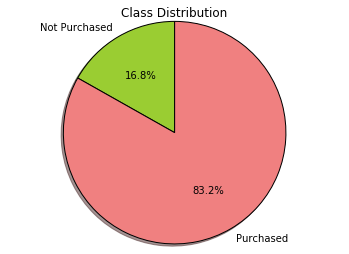

In [6]:
%matplotlib inline
labels = 'Not Purchased', 'Purchased'
positive = sum(data['lapse7'] == 1)
negative = sum(data['lapse7'] == 0)
sizes = [positive, negative]
colors = ['yellowgreen', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title("Class Distribution")
plt.show()

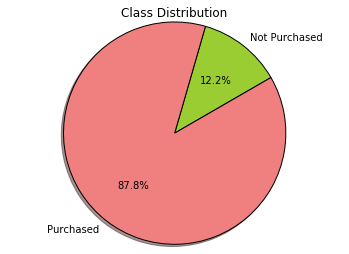

In [7]:
positive = sum(data['lapse14'] == 1)
negative = sum(data['lapse14'] == 0)
sizes = [positive, negative]
colors = ['yellowgreen', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=30)
plt.axis('equal')
plt.title("Class Distribution")
plt.show()

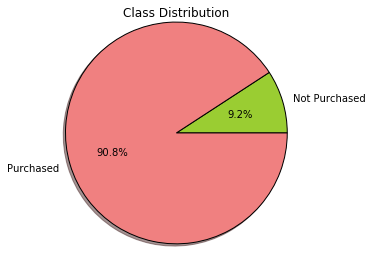

In [8]:
positive = sum(data['lapse30'] == 1)
negative = sum(data['lapse30'] == 0)
sizes = [positive, negative]
colors = ['yellowgreen', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=0)
plt.axis('equal')
plt.title("Class Distribution")
plt.show()

We see that as we increase our lapse period, the number of transactions that do not churn decreases.

# Feature Engineering 1
 Features that represent unique IDs are not generalizable for classification and should be removed.

In [112]:
del data['idfa']
del data['rn']

We may want to convert `event_time` to a time stamp. For example, `event_time` could be converted to a feature that represents the number of minutes from or to midnight, whichever is less. This time stamp may be potentially useful because it is possible more frequent transactions may occur at a different time of the day than less frequent transactions. 

### Date Time
First check what data structure `event_time` is stored as

In [113]:
print(data['event_time'][0])
print(type(data['event_time'][0]))

2016-03-22 23:11:58
<class 'str'>


Looks like it is a string, therefore we need to convert to datetime format, which can in turn be used to calculate the time to/from midnight.

In [114]:
temp = np.squeeze(data.as_matrix(['event_time']))
# Transform datetime.strptime function so that it can vectorize
func = np.vectorize(datetime.strptime)
dtVec = func(temp, "%Y-%m-%d %H:%M:%S")
print(dtVec[:5])

[datetime.datetime(2016, 3, 22, 23, 11, 58)
 datetime.datetime(2016, 3, 1, 12, 14, 37)
 datetime.datetime(2016, 3, 14, 0, 27, 2)
 datetime.datetime(2016, 3, 3, 22, 50, 33)
 datetime.datetime(2016, 3, 4, 3, 20, 3)]


Let us define a function that converts our event times to closest time from/to midnight in minutes. For example, 23:56 pm would result in 4 minutes, 11:55 am would result in 715 minutes, and 13:00 pm would result in 660 minutes. There are 1440 minutes in a day.

In [115]:
def TimeToFromMidnight(dt):
    h = dt.hour
    m = dt.minute
    mTotal = h*60 + m
    if (1440 - mTotal > mTotal):
        return mTotal
    else:
        return (1440 - mTotal)

Perform transformation from event times to minutes to/from midnight.

In [116]:
TimeToFromMidnightVec = np.vectorize(TimeToFromMidnight)
times = TimeToFromMidnightVec(dtVec)
print(times[:10])

[ 49 706  27  70 200 233  14 373 185 201]


Add this new timestamp feature to our dataframe

In [117]:
data['timeMN'] = times

Delete original `event_time` data

In [118]:
del data['event_time']

Let's visualize the distribution of time stamp for churn and non-churn transactions to see if certain transactions have any time preferences between the two classes.

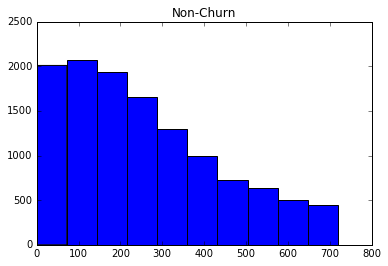

In [119]:
%matplotlib inline
posTime = np.squeeze(data.loc[(data['lapse7'] == 1), ['timeMN']]).astype('int')
negTime = np.squeeze(data.loc[(data['lapse7'] == 0), ['timeMN']]).astype('int')
plt.hist([posTime])
plt.title("Non-Churn")
plt.show()

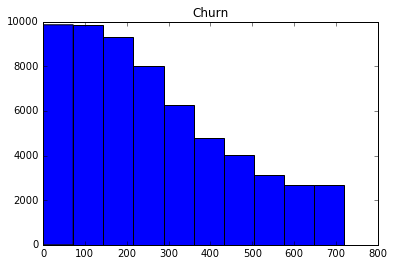

In [120]:
plt.hist([negTime])
plt.title("Churn")
plt.show()

There doesn't appear to be any preference in purchase time between churn and non-churn transactions. However, it is noteworthy that in general, there is a preference for purchasing close to midnight (~3 hours within midnight). A possible explanation for this is that Viva Slots customers have more time to play and pay during the evenings when have less time during the day due to work.

### Email Status

Convert email status to binary so that we can work with numbers

In [121]:
data['hasemail'] = data['hasemail'].astype(int)
print(data['hasemail'][:5])

0    1
1    1
2    1
3    0
4    1
Name: hasemail, dtype: int64


The rationale for including whether user associated with transaction has provided email is because providing email awards the user with in-game credits. However, this is a one-time event and may not be useful in separating churn from non-churn transactions.

In [122]:
print("Proportion of churn transactions with email: ")
print(np.mean(data.loc[(data['lapse7'] == 1), ['hasemail']]))

Proportion of churn transactions with email: 
hasemail    0.488395
dtype: float64


In [123]:
print("Proportion of non-churn transactions with email: ")
print(np.mean(data.loc[(data['lapse7'] == 0), ['hasemail']]))

Proportion of non-churn transactions with email: 
hasemail    0.497487
dtype: float64


Indeed, the proportion of transactions providing email is similar in both classes at around 50%, almost like tossing a coin on each transaction to decide whether the user for the transaction provided email! Some additional features will be constructed based on which lapse we choose, and we choose `lapse7` as the default. First save the data so far.

In [124]:
pickle.dump(data, open(dataDir + "data.p", 'wb'))

Load the data back up

In [125]:
data = pickle.load(open(dataDir + "data.p", 'rb'))

### Hours Prior to Current Purchase

We need to throw away `hours_until` because that feature is used to determine our label (i.e. if `hours_until` > 7 then 1 else 0). However, we can keep `hours_prior` to current purchase.

We want to see if we should keep `hours_prior`, which contains `(null)` values corresponding to no purchases prior to current purchase. Inclusion of `hours_prior` requires a strategy for treating `(null)` values. First see how many `(null)` values there are as a percentage of our data.

In [126]:
print("Percentage null: ")
np.mean(data['hours_prior'] == '(null)')

Percentage null: 


0.070324278391491468

A sizeable number of samples have `(null)`, hence we continue on to see if `hours_prior` is worth including:

In [127]:
pos = np.squeeze(data.loc[(data['hours_prior'] != '(null)') & (data['lapse7'] == 1), ['hours_prior']]).astype('int')
print(pos.shape)
neg = np.squeeze(data.loc[(data['hours_prior'] != '(null)') & (data['lapse7'] == 0), ['hours_prior']]).astype('int')
print(neg.shape)

(9757,)
(58074,)


In [128]:
print(pos.describe())
print(neg.describe())

count    9757.000000
mean     -195.475556
std       313.981365
min     -2178.000000
25%      -237.000000
50%       -62.000000
75%        -4.000000
max         0.000000
Name: hours_prior, dtype: float64
count    58074.000000
mean       -42.216878
std        126.783217
min      -2146.000000
25%        -27.000000
50%         -3.000000
75%          0.000000
max          0.000000
Name: hours_prior, dtype: float64


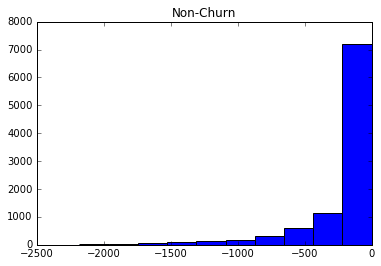

In [129]:
plt.hist([pos])
plt.title("Non-Churn")
plt.show()

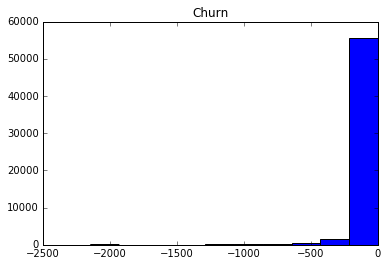

In [130]:
plt.hist([neg])
plt.title("Churn")
plt.show()

It appears that non-churn transactions have a larger within-class proportion of transactions who have hours prior to current payment greater than 250 hours. A possible explanation is that non-churn transactions in general have longer time span between successive purchases. Thus, `hours_prior` may be useful and should be included.

To treat the `(null)` values, we are going to impute them with the mean `hours_prior` values of transactions within the same class.

In [131]:
posMean = int(np.mean(pos))
negMean = int(np.mean(neg))
data.loc[(data['lapse7'] == 1) & (data['hours_prior'] == '(null)'), ['hours_prior']] = posMean
data.loc[(data['lapse7'] == 0) & (data['hours_prior'] == '(null)'), ['hours_prior']] = negMean

We should delete `hours_until`

In [132]:
del data['hours_until']

Save the data

In [133]:
pickle.dump(data, open(dataDir + "data.p", 'wb'))

Load the data

In [51]:
data = pickle.load(open(dataDir + "data.p", 'rb'))

# Data Visualization

First set the labels

In [134]:
y1 = data['lapse7']
y2 = data['lapse14']
y3 = data['lapse30']
del data['lapse7']
del data['lapse14']
del data['lapse30']

Determine the dimensions of the data matrix

In [135]:
data.shape

(72962, 135)

Scale each feature in the data matrix so that each feature has zero mean and unit variance. This is almost always a necessary step for PCA and a step that cannot hurt to perform.

In [136]:
dataScale = pp.scale(data)

Let us whiten the data and plot a PCA of the total data

In [137]:
pca = PCA(n_components=135, whiten=True)
pca_transformed = pca.fit_transform(dataScale)

Plotting...

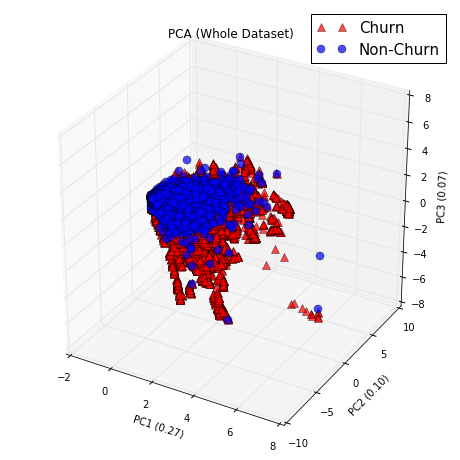

In [138]:
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
posIdx = np.where(y1 == 1)[0]
negIdx = np.where(y1 == 0)[0]
ax.plot(pca_transformed[negIdx,0], pca_transformed[negIdx, 1], pca_transformed[negIdx, 2], '^', markersize=8, 
        alpha=0.7, color='red', label='Churn')
ax.plot(pca_transformed[posIdx, 0], pca_transformed[posIdx, 1], pca_transformed[posIdx, 2], 'o', markersize=8, 
        color='blue', alpha=0.7, label='Non-Churn')
ax.set_xlabel('PC1 (%.2f)' % (pca.explained_variance_ratio_[0]))
ax.set_ylabel('PC2 (%.2f)'% (pca.explained_variance_ratio_[1]))
ax.set_zlabel('PC3 (%.2f)' % (pca.explained_variance_ratio_[2]))
plt.title("PCA (Whole Dataset)")
ax.legend(loc='upper right')
plt.show()

Based on the plot alone it looks like there is a great deal of overlap between our classes. However, the overlap is not perfect, so it is possible to separate out the true negatives. However, plenty of false positives and false negatives are expected because plenty of samples from different classes share very similar features. Let us see how well our three components "capture" the total structure of the data.

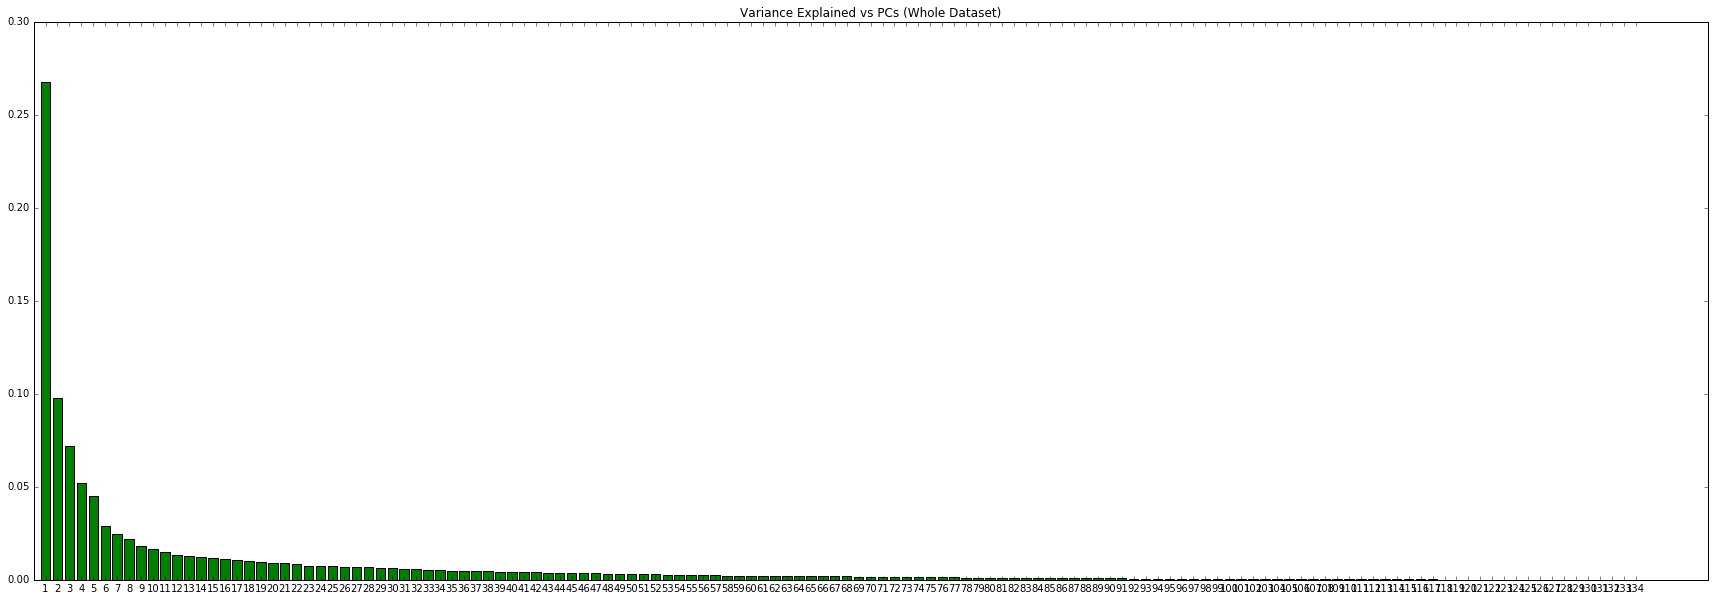

In [139]:
plt.figure(figsize=(30,10))
plt.title("Variance Explained vs PCs (Whole Dataset)")
plt.bar(list(range(1, len(pca.explained_variance_ratio_) + 1)), pca.explained_variance_ratio_,
       color="g", align="center")
plt.xticks(list(range(1, len(pca.explained_variance_ratio_))), list(range(1, len(pca.explained_variance_ratio_))))
plt.show()

It looks like our first three PCs do a reasonable job in capturing the structure of the data compared with the rest of the components. Let us perform PCA again, but this time without the time series data to assess the performance of the non-time series data alone. We need to first subset the data so that only non-time series data are included.

In [140]:
dataSubset = dataScale[:, list(range(8)) + [134]]
pca = PCA(n_components=9, whiten=True)
pca_transformed = pca.fit_transform(dataSubset)

Plot:

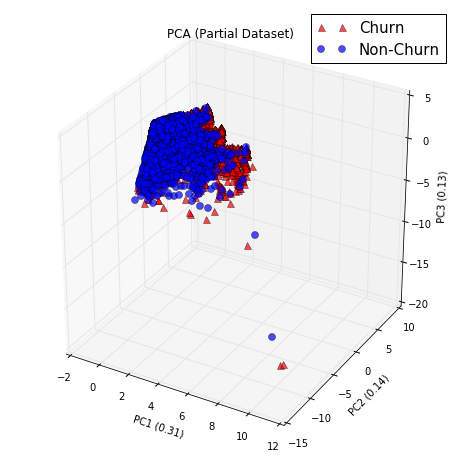

In [141]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
posIdx = np.where(y1 == 1)[0]
negIdx = np.where(y1 == 0)[0]
ax.plot(pca_transformed[negIdx,0], pca_transformed[negIdx, 1], pca_transformed[negIdx, 2], '^', 
        markersize=7, alpha=0.7, color='red', label='Churn')
ax.plot(pca_transformed[posIdx, 0], pca_transformed[posIdx, 1], pca_transformed[posIdx, 2], 'o', 
        markersize=7, color='blue', alpha=0.7, label='Non-Churn')
ax.set_xlabel('PC1 (%.2f)' % (pca.explained_variance_ratio_[0]))
ax.set_ylabel('PC2 (%.2f)'% (pca.explained_variance_ratio_[1]))
ax.set_zlabel('PC3 (%.2f)' % (pca.explained_variance_ratio_[2]))
plt.title("PCA (Partial Dataset)")
ax.legend(loc='upper right')
plt.show()

Keeping the time series data makes the data look more separable. Let's look at the data two components at a time.

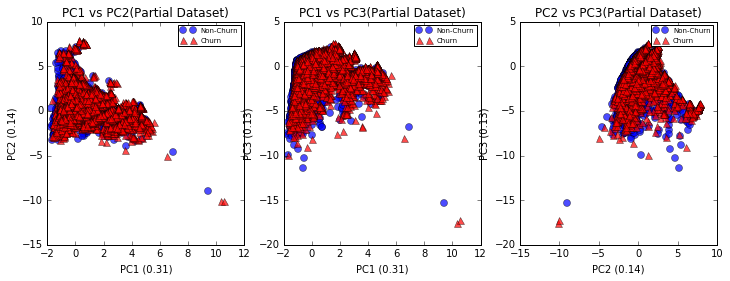

In [142]:
fig = plt.figure(figsize=(12,4))
PCs = [(0, 1), (0, 2), (1, 2)]
i = 1
for pc in PCs:
    ax = fig.add_subplot(130 + i)
    ax.plot(pca_transformed[posIdx, pc[0]], pca_transformed[posIdx, pc[1]], 'o', markersize=7, color='blue', 
            alpha=0.7, label='Non-Churn')
    ax.plot(pca_transformed[negIdx,pc[0]], pca_transformed[negIdx, pc[1]], '^', markersize=7, alpha=0.7, 
            color='red', label='Churn')
    ax.set_xlabel('PC' + str(pc[0] + 1) + ' (%.2f)' % (pca.explained_variance_ratio_[pc[0]]))
    ax.set_ylabel('PC' + str(pc[1] + 1) + ' (%.2f)'% (pca.explained_variance_ratio_[pc[1]]))
    plt.rcParams['legend.fontsize'] = 7
    plt.title("PC" + str(pc[0] + 1) + " vs " + "PC" + str(pc[1] + 1) +  "(Partial Dataset)")
    ax.legend(loc='upper right')
    i += 1
plt.show()

Indeed, the non-time series features alone will not be very useful in distinguishing the two classes. 

Let us plot each time-series feature mean against time to see if there are any differences between churn and no churn. In the plots below, increasing time values indicate intervals closer to purchase (ie. `ooc_21_14d` vs `ooc_2_1d`). Keep in mind that for each time-series feature, there are two groups of intervals - intervals over 7 days and intervals over 1 day. Intervals closer to purchase are defined over a day. Bars included represent the standard deviation.

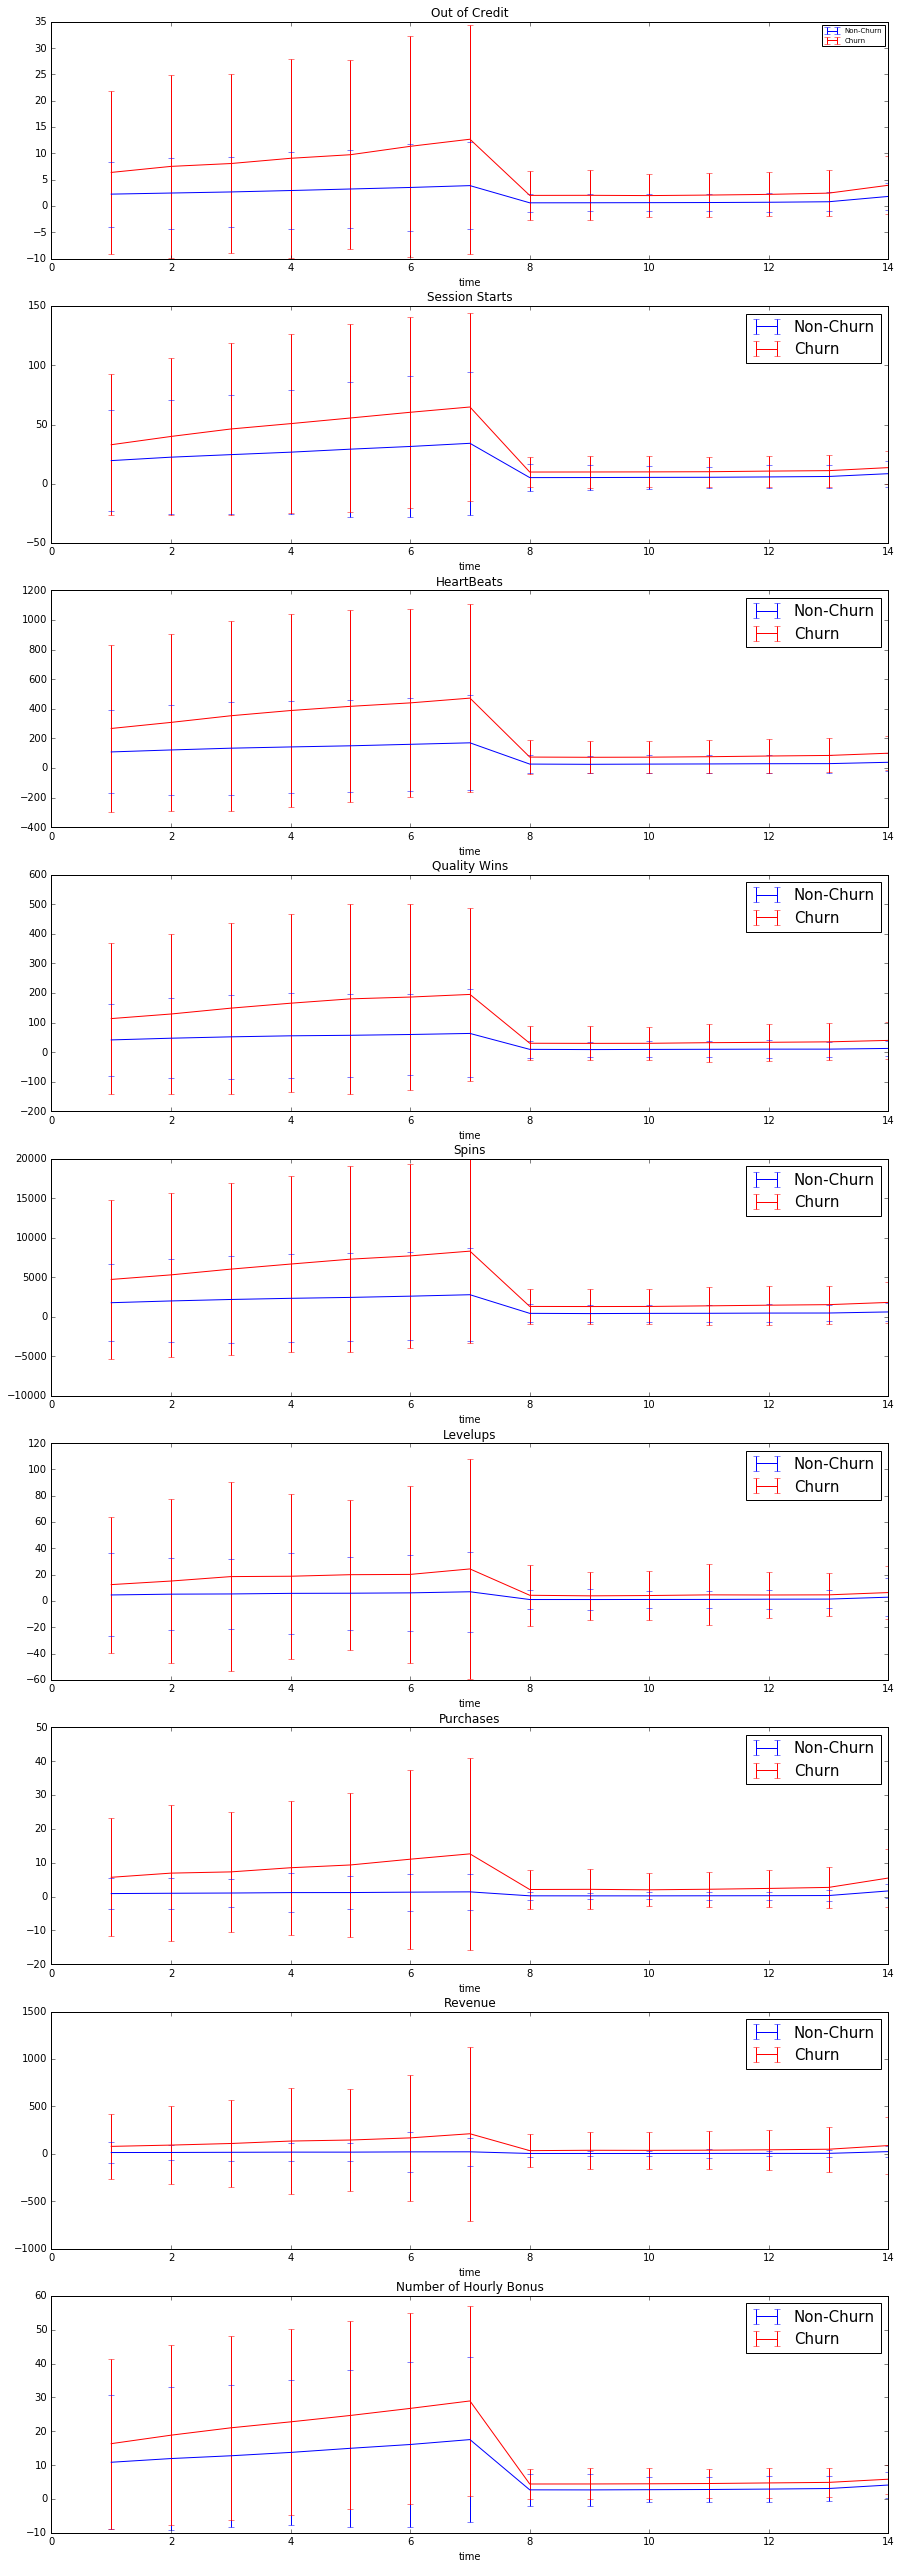

In [143]:
dataSubset = data.ix[:, 8:134]
fig = plt.figure(figsize = (15, 45))
titles = ["Out of Credit", "Session Starts", "HeartBeats", "Quality Wins", "Spins", "Levelups", "Purchases", 
         "Revenue", "Number of Hourly Bonus"]
counter = 0
for i in range(0, 126, 14):
    ax = fig.add_subplot(910 + counter + 1)
    pos = dataSubset.ix[posIdx, i:i+14]
    neg = dataSubset.ix[negIdx, i:i+14]
    posMean = pos.apply(np.mean)
    negMean = neg.apply(np.mean)
    posStd = pos.apply(np.std)
    negStd = neg.apply(np.std)
    ax.errorbar(list(range(1, 15)), posMean, yerr=posStd, color='blue', label="Non-Churn")
    ax.errorbar(list(range(1, 15)), negMean, yerr=negStd, color='red', label="Churn")
    ax.set_xlabel("time")
    ax.set_title(titles[counter])
    ax.legend(loc='upper right')
    plt.rcParams['legend.fontsize'] = 15
    counter += 1

A couple of observations can be made from these plots:

1. In general, churn players have higher mean feature values than non-churn players, although the significance of the difference may not be high.
2. In general, churn players have larger standard deviations than non-churn players.

These observations suggest that churn transactions in general are more diverse than non-churn playes. 

# Feature Engineering 2
### Number of Times Exceeding 1-2 SD
Since churn players seem to be more diverse, they may be diverse because churn players have more volatile in-game experiences. We will leverage this to create new features as the number of times a feature value exceeds or goes below 1-2 standard deviations from the mean value over time, and see if it is a good feature.

In [144]:
newFeatures = {}
features = ["oocNew", "ssNew", "hbNew", "qwNew", "spinsNew", "luNew", "purchaseNew", 
         "revNew", "bonusNew"]
posIdx = np.where(y1 == 1)[0]
negIdx = np.where(y1 == 0)[0]
counter = 0

for i in range(0, 126, 14):
    sub = dataSubset.ix[:, i:i+14].as_matrix()
    means = np.mean(sub, axis=1).reshape(sub.shape[0], 1)
    stds = np.std(sub, axis=1).reshape(sub.shape[0], 1)
    truth = (sub > means + 1*stds) | (sub < means - 1*stds)
    newFeatures[counter] = np.sum(truth, axis=1)
    counter += 1

newFeatures = pd.DataFrame(newFeatures)
newFeatures.columns = features
newFeatures.head()

,oocNew,ssNew,hbNew,qwNew,spinsNew,luNew,purchaseNew,revNew,bonusNew
0,3,4,4,1,1,1,2,2,4
1,1,2,1,1,1,1,1,2,1
2,1,1,2,2,2,2,1,1,2
3,1,8,4,5,5,7,7,7,5
4,2,1,2,1,2,2,1,1,1


Let us see how well our newly created features separate out churn players from non-churn players.

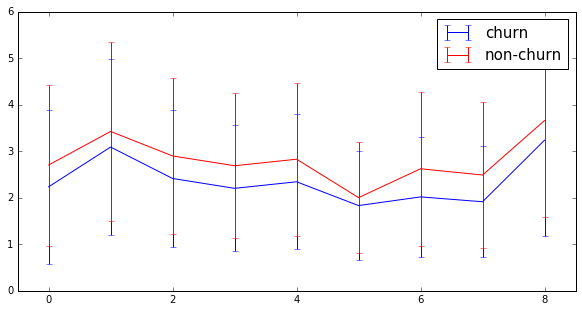

In [145]:
newFeatures = newFeatures.as_matrix()
pos = newFeatures[posIdx, :]
neg = newFeatures[negIdx, :]
posMeans = np.mean(pos, axis=0)
posStds = np.std(pos, axis=0)
negMeans = np.mean(neg, axis=0)
negStds = np.std(neg, axis=0)
plt.figure(figsize = (10, 5))
plt.errorbar(list(range(len(features))), posMeans, yerr=posStds, color="blue", label="churn")
plt.errorbar(list(range(len(features))), negMeans, yerr=negStds, color="red", label="non-churn")
plt.xlim([-0.5, 8.5])
plt.legend(loc="upper right")
plt.show()

Unfortunately this new feature doesn't seem to capture the differences well. However, there is little harm to adding this new feature.

In [146]:
data = pickle.load(open(dataDir + "data.p", 'rb'))
newFeatures = pd.DataFrame(newFeatures)
newFeatures.columns = features
data = pd.concat([data, newFeatures], axis=1)
pickle.dump(data, open(dataDir + "data.p", 'wb'))

Load the data

In [150]:
data = pickle.load(open(dataDir + "data.p", 'rb'))

### Range
Given that churn transactions are more volatile, let us construct a new feature using range (measure of dispersion) over time for each of the 9 time-series features as new features.

In [152]:
newFeatures = {}
features = ["oocRange", "ssRange", "hbRange", "qwRange", "spinsRange", "luRange", "purchaseRange", 
         "revRange", "bonusRange"]
counter = 0

for i in range(0, 126, 14):
    sub = dataSubset.ix[:, i:i+14].as_matrix()
    maxVal = np.max(sub, axis=1)
    minVal = np.min(sub, axis=1)
    r = maxVal - minVal
    newFeatures[counter] = r
    counter += 1

newFeatures = pd.DataFrame(newFeatures)
newFeatures.columns = features
newFeatures.head()

,oocRange,ssRange,hbRange,qwRange,spinsRange,luRange,purchaseRange,revRange,bonusRange
0,44,258,563,625,21604,78,17,259.83,83
1,6,32,254,187,5392,5,34,66.66,19
2,28,175,1116,441,23790,27,14,554.86,79
3,4,60,1268,278,14508,4,2,29.98,47
4,3,4,98,48,1769,33,18,149.82,3


Let's visualize how well this new feature does at separating classes using histograms

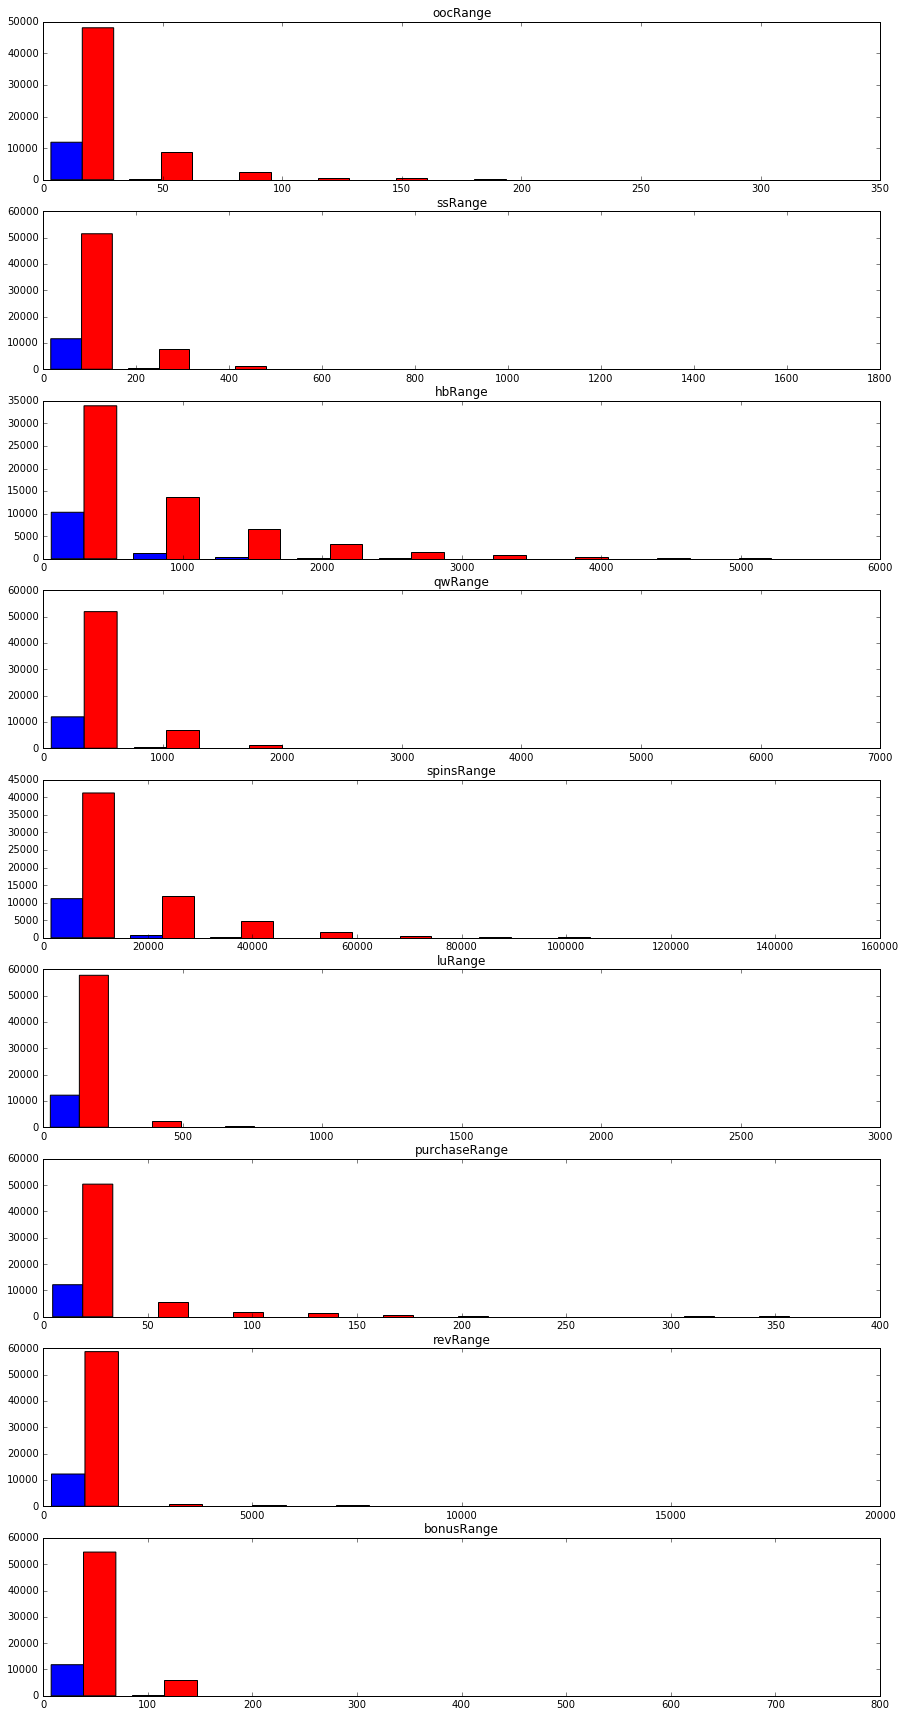

In [153]:
fig = plt.figure(figsize = (15, 30))
posIdx = np.where(y1 == 1)[0]
negIdx = np.where(y1 == 0)[0]
pos = newFeatures.iloc[posIdx, :]
neg = newFeatures.iloc[negIdx, :]
counter = 1
n = 20
for feature in features:
    ax = fig.add_subplot(910 + counter)
    posF = pos[feature]
    negF = neg[feature]
    ax.hist([posF, negF], color=['blue', 'red'], label=['Non-churn', 'Churn'])
    ax.set_title(feature)
    counter += 1

It looks like this feature may capture the class differences, as non-churn trasactions generally have lower maximum values for each of the 9 features.

In [156]:
newData = pd.concat([data, newFeatures], axis=1)
print(data.shape)
print(newData.shape)

(72962, 147)
(72962, 156)


In [161]:
pickle.dump(newData, open(dataDir + "data.p", 'wb'))

# New Feature Visualization

To gauge how well the best engineered features perform in separating classes, we will perform PCA. First load the data

In [162]:
data7 = pickle.load(open(dataDir + "data.p", 'rb'))
y7 = data7['lapse7']
del data7['lapse7']
del data7['lapse14']
del data7['lapse30']

Then subset the features to only included the best engineered features, determined to be the `hours_prior` and range features.

In [163]:
data7 = data7.ix[:, ['hours_prior', "oocRange", "ssRange", "hbRange", "qwRange", "spinsRange", "luRange", 
                     "purchaseRange", "revRange", "bonusRange"]]
print(data7.shape)

(72962, 10)


Scale and fit the data

In [164]:
data7 = pp.scale(data7)
pca = PCA(n_components=10, whiten=True)
pca_transformed = pca.fit_transform(data7)

Plot

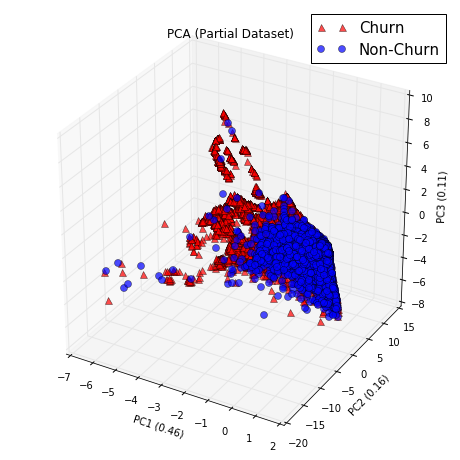

In [165]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
posIdx = np.where(y7 == 1)[0]
negIdx = np.where(y7 == 0)[0]
ax.plot(pca_transformed[negIdx,0], pca_transformed[negIdx, 1], pca_transformed[negIdx, 2], '^', 
        markersize=7, alpha=0.7, color='red', label='Churn')
ax.plot(pca_transformed[posIdx, 0], pca_transformed[posIdx, 1], pca_transformed[posIdx, 2], 'o', 
        markersize=7, color='blue', alpha=0.7, label='Non-Churn')
ax.set_xlabel('PC1 (%.2f)' % (pca.explained_variance_ratio_[0]))
ax.set_ylabel('PC2 (%.2f)'% (pca.explained_variance_ratio_[1]))
ax.set_zlabel('PC3 (%.2f)' % (pca.explained_variance_ratio_[2]))
plt.title("PCA (Partial Dataset)")
ax.legend(loc='upper right')
plt.show()

It looks like these new features can provide some degree of class separation. Let us visualize the PCA plot with all features.

In [166]:
data7 = pickle.load(open(dataDir + "data.p", 'rb'))
y7 = data7['lapse7']
del data7['lapse7']
del data7['lapse14']
del data7['lapse30']

Scale and fit the data

In [168]:
data7 = pp.scale(data7)
pca = PCA(n_components=153, whiten=True)
pca_transformed = pca.fit_transform(data7)

Plot

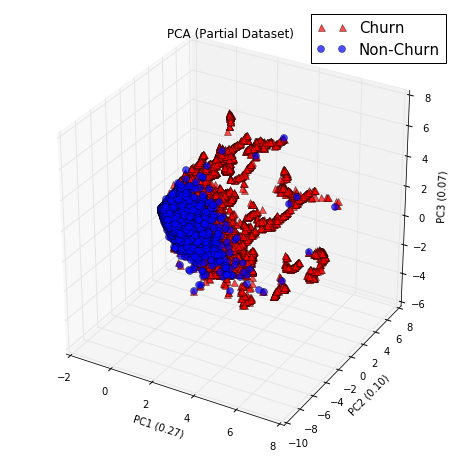

In [169]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
posIdx = np.where(y7 == 1)[0]
negIdx = np.where(y7 == 0)[0]
ax.plot(pca_transformed[negIdx,0], pca_transformed[negIdx, 1], pca_transformed[negIdx, 2], '^', 
        markersize=7, alpha=0.7, color='red', label='Churn')
ax.plot(pca_transformed[posIdx, 0], pca_transformed[posIdx, 1], pca_transformed[posIdx, 2], 'o', 
        markersize=7, color='blue', alpha=0.7, label='Non-Churn')
ax.set_xlabel('PC1 (%.2f)' % (pca.explained_variance_ratio_[0]))
ax.set_ylabel('PC2 (%.2f)'% (pca.explained_variance_ratio_[1]))
ax.set_zlabel('PC3 (%.2f)' % (pca.explained_variance_ratio_[2]))
plt.title("PCA (Partial Dataset)")
ax.legend(loc='upper right')
plt.show()

The separation is a little better, which suggests we also need our existing time-series data.

# Which Lapse is Better?

Rocket Games is interested in high recall of non-churn transactions, so the optimization objective is to maximize the area under the precision-recall curve. However, this depends on how we define non-churn transactions. We have the options of 7 days, 14 days, or even 30 days. Which definition is chosen will depend on the tradeoff between AUCs and how frequent Rocket Games would like the purchases to be. Let us first contruct the `hours_prior` feature for `lapse14` and `lapse30` respectively, and compare all the AUCs to see which lapse will allow both maximal recall and precision.

In [66]:
data = pickle.load(open(dataDir + "data.p", 'rb'))

### Lapse14

Impute the `hours_prior` feature

In [67]:
data14 = copy.deepcopy(data)
pos = np.squeeze(data14.loc[(data14['hours_prior'] != '(null)') & (data14['lapse14'] == 1), 
                          ['hours_prior']]).astype('int')
print(pos.shape)
neg = np.squeeze(data14.loc[(data14['hours_prior'] != '(null)') & (data14['lapse14'] == 0), 
                              ['hours_prior']]).astype('int')
print(neg.shape)

(8900,)
(64062,)


In [69]:
posMean = int(np.mean(pos))
negMean = int(np.mean(neg))
data14.loc[(data14['lapse14'] == 1) & (data14['hours_prior'] == '(null)'), ['hours_prior']] = posMean
data14.loc[(data14['lapse14'] == 0) & (data14['hours_prior'] == '(null)'), ['hours_prior']] = negMean

In [70]:
y14 = data14['lapse14']
del data14['lapse7']
del data14['lapse30']
del data14['lapse14']

### Lapse 30
Impute the `hours_prior` feature

In [71]:
data30 = copy.deepcopy(data)
pos = np.squeeze(data30.loc[(data30['hours_prior'] != '(null)') & (data30['lapse30'] == 1), 
                          ['hours_prior']]).astype('int')
print(pos.shape)
neg = np.squeeze(data30.loc[(data30['hours_prior'] != '(null)') & (data30['lapse30'] == 0), 
                              ['hours_prior']]).astype('int')
print(neg.shape)

(6708,)
(66254,)


In [72]:
posMean = int(np.mean(pos))
negMean = int(np.mean(neg))
data30.loc[(data30['lapse30'] == 1) & (data30['hours_prior'] == '(null)'), ['hours_prior']] = posMean
data30.loc[(data30['lapse30'] == 0) & (data30['hours_prior'] == '(null)'), ['hours_prior']] = negMean

In [73]:
y30 = data30['lapse30']
del data30['lapse7']
del data30['lapse14']
del data30['lapse30']

### Comparison

We will use a decision tree to roughly evaluate the area under the precison-recall curve when the label is defined according to `lapse7`, `lapse14` and `lapse30` respectively. We will pick the definition that allows us to achieve maximum area under the precision-recall curve. 

#### Lapse 7

Set the label for lapse7 and delete all the other labels

In [74]:
data7 = copy.deepcopy(data)
y7 = data7['lapse7']
del data7['lapse7']
del data7['lapse14']
del data7['lapse30']

We use the 80-20 split rule for train and test sets

In [75]:
Xtrain, Xtest, ytrain, ytest = train_test_split(data7, y7, test_size=0.20)

Let us first do hyperparameter tuning to determine the optimal tree depth for our decision tree. We choose the `class_weight` to be "balanced" because we have a class imbalance with a majority negative class. 

In [76]:
dt = DecisionTreeClassifier(class_weight="balanced")
depths = {'max_depth':list(range(4, 26, 2))}
clf = grid_search.GridSearchCV(dt, depths, scoring='average_precision', cv=3, verbose=True)
clf.fit(Xtrain, ytrain)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  2.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=True)

Look at all the scores

In [77]:
clf.grid_scores_

[mean: 0.64258, std: 0.00536, params: {'max_depth': 4},
 mean: 0.64809, std: 0.00878, params: {'max_depth': 6},
 mean: 0.63109, std: 0.01206, params: {'max_depth': 8},
 mean: 0.59992, std: 0.01140, params: {'max_depth': 10},
 mean: 0.56064, std: 0.00961, params: {'max_depth': 12},
 mean: 0.52734, std: 0.00821, params: {'max_depth': 14},
 mean: 0.49978, std: 0.00865, params: {'max_depth': 16},
 mean: 0.49173, std: 0.00721, params: {'max_depth': 18},
 mean: 0.48886, std: 0.00782, params: {'max_depth': 20},
 mean: 0.49002, std: 0.00620, params: {'max_depth': 22},
 mean: 0.48552, std: 0.00071, params: {'max_depth': 24}]

It looks like the optimal maximum tree depth is 6. 

In [78]:
clf = DecisionTreeClassifier(max_depth=6, class_weight="balanced")
clf.fit(Xtrain, ytrain)
print("Prediction accuracy on test dataset: ")
print(clf.score(Xtest, ytest))

Prediction accuracy on test dataset: 
0.743644212979


Now evaluate area under precision-recall (PR) curve

In [79]:
prob = clf.predict_proba(Xtest)[:, 1]
area = average_precision_score(ytest, prob)
print("Area under PR Curve")
print(area)

Area under PR Curve
0.644474151547


Let us finally plot the precision-recall curve.

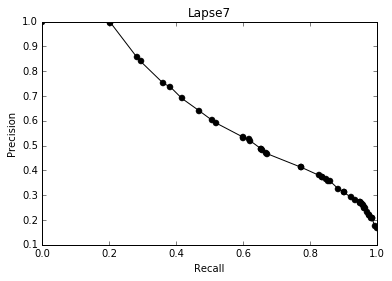

In [80]:
precision, recall, thresholds = precision_recall_curve(ytest, prob)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse7")
plt.show()

#### Lapse14

We use the 80-20 split rule for train and test sets

In [81]:
Xtrain, Xtest, ytrain, ytest = train_test_split(data14, y14, test_size=0.20)

Let us first do hyperparameter tuning to determine the optimal tree depth for our decision tree. We choose the `class_weight` to be "balanced" because we have a class imbalance with a majority negative class. Based on the previous run for `lapse7`, it appears that a tall decision tree leads to suboptimal area under the PR curve, so this will decrease the number of hyperparameters we need to tune this time.

In [82]:
dt = DecisionTreeClassifier(class_weight="balanced")
depths = {'max_depth':list(range(4, 16, 2))}
clf = grid_search.GridSearchCV(dt, depths, scoring='average_precision', cv=3, verbose=True)
clf.fit(Xtrain, ytrain)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   53.7s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [4, 6, 8, 10, 12, 14]},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=True)

Look at all the scores

In [84]:
clf.grid_scores_

[mean: 0.57857, std: 0.00973, params: {'max_depth': 4},
 mean: 0.45984, std: 0.01106, params: {'max_depth': 6},
 mean: 0.45852, std: 0.01107, params: {'max_depth': 8},
 mean: 0.43343, std: 0.01152, params: {'max_depth': 10},
 mean: 0.41279, std: 0.01012, params: {'max_depth': 12},
 mean: 0.38280, std: 0.01001, params: {'max_depth': 14}]

It looks like the optimal maximum tree depth is 4. 

In [85]:
clf = DecisionTreeClassifier(max_depth=4, class_weight="balanced")
clf.fit(Xtrain, ytrain)
print("Prediction accuracy on test dataset: ")
print(clf.score(Xtest, ytest))

Prediction accuracy on test dataset: 
0.759679298294


Now evaluate area under precision-recall (PR) curve

In [86]:
prob = clf.predict_proba(Xtest)[:, 1]
area = average_precision_score(ytest, prob)
print("Area under PR Curve")
print(area)

Area under PR Curve
0.579786068289


Let us finally plot the precision-recall curve.

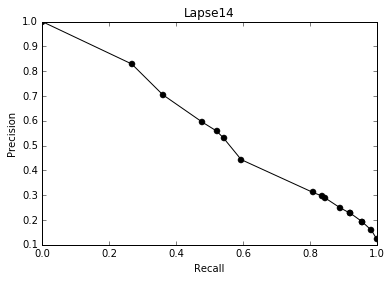

In [87]:
precision, recall, thresholds = precision_recall_curve(ytest, prob)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse14")
plt.show()

#### Lapse30

We use the 80-20 split rule for train and test sets

In [88]:
Xtrain, Xtest, ytrain, ytest = train_test_split(data30, y30, test_size=0.20)

Hyperparameter tuning to determine the optimal tree depth

In [89]:
dt = DecisionTreeClassifier(class_weight="balanced")
depths = {'max_depth':list(range(4, 16, 2))}
clf = grid_search.GridSearchCV(dt, depths, scoring='average_precision', cv=3, verbose=True)
clf.fit(Xtrain, ytrain)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   50.6s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [4, 6, 8, 10, 12, 14]},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=True)

Look at the scores

In [90]:
clf.grid_scores_

[mean: 0.53372, std: 0.00349, params: {'max_depth': 4},
 mean: 0.44070, std: 0.07182, params: {'max_depth': 6},
 mean: 0.39809, std: 0.01404, params: {'max_depth': 8},
 mean: 0.37378, std: 0.00588, params: {'max_depth': 10},
 mean: 0.34937, std: 0.00540, params: {'max_depth': 12},
 mean: 0.33167, std: 0.00897, params: {'max_depth': 14}]

The most optimal depth is 4

In [91]:
clf = DecisionTreeClassifier(max_depth=4, class_weight="balanced")
clf.fit(Xtrain, ytrain)
print("Prediction accuracy on test dataset: ")
print(clf.score(Xtest, ytest))

Prediction accuracy on test dataset: 
0.783183718221


Now evaluate area under precision-recall (PR) curve

In [92]:
prob = clf.predict_proba(Xtest)[:, 1]
area = average_precision_score(ytest, prob)
print("Area under PR Curve")
print(area)

Area under PR Curve
0.509707293773


Plot the precision-recall curve

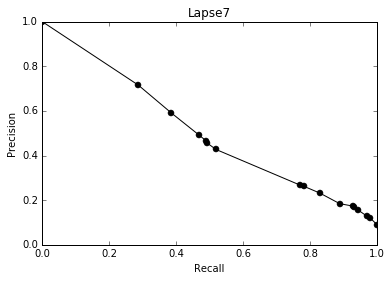

In [93]:
precision, recall, thresholds = precision_recall_curve(ytest, prob)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse7")
plt.show()

It appears that lapse7 gives us the best area under the PR curve. 

# Feature Selection

We are interested in which features are the best at discriminating classes. Since a decision tree automatically performs feature selection, we will leverage this property to help us determine that. 

In [170]:
data = pickle.load(open(dataDir + "data.p", 'rb'))
y = data['lapse7']
del data['lapse7']
del data['lapse14']
del data['lapse30']

Let us first split the dataset and train on a simple decision tree to gauge its performance again.

In [171]:
Xtrain, Xtest, ytrain, ytest = train_test_split(data, y, test_size=0.2)
clf = DecisionTreeClassifier(max_depth=8, class_weight="balanced")
clf.fit(Xtrain, ytrain)
pred = clf.predict(Xtest)
print("Prediction accuracy on test dataset: ")
print(clf.score(Xtest, ytest))

Prediction accuracy on test dataset: 
0.767491262934


Determine the recall score based on 50% decision threshold

In [172]:
pred = clf.predict(Xtest)
print(recall_score(ytest, pred))

0.778559602649


Confusion Matrix

In [173]:
pd.crosstab(ytest, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,9319,2858,12177
1,535,1881,2416
All,9854,4739,14593


 Area under the curve

In [174]:
prob = clf.predict_proba(Xtest)[:, 1]
area = average_precision_score(ytest, prob)
print("Area under PR Curve")
print(area)

Area under PR Curve
0.638255546598


From all the analysis we have done so far, since there appears to be a significant overlap between positive and negative classes, there is going to be a significant tradeoff between recall and precision. Let us save our splitted dataset.

In [175]:
pickle.dump(Xtrain, open(dataDir + "Xtrain.p", 'wb'))
pickle.dump(ytrain, open(dataDir + "ytrain.p", 'wb'))
pickle.dump(Xtest, open(dataDir + "Xtest.p", 'wb'))
pickle.dump(ytest, open(dataDir + "ytest.p", 'wb'))

Load our modified dataset

In [25]:
Xtrain = pickle.load(open(dataDir + "Xtrain.p", "rb"))
ytrain = pickle.load(open(dataDir + "ytrain.p", "rb"))
Xtest = pickle.load(open(dataDir + "Xtest.p", "rb"))
ytest = pickle.load(open(dataDir + "ytest.p", "rb"))

Import Calvin's decision tree, which will output all the top features used to separate the classes.

In [177]:
from DecisionTree import DecisionTree

Train the decision tree

In [178]:
clf2 = DecisionTree(stop=0.35, output=True, minSize=1000)
clf2.train(Xtrain, ytrain)

Let's see how well Calvin's decision tree performs on the test set.

In [179]:
pred = clf2.predict(Xtest)
print("Test set accuracy:")
print(np.mean(pred == ytest))

Test set accuracy:
0.872747207565


In [180]:
attributes = clf2.attributes
print(attributes)

['hours_prior', 'purchaseRange', 'lu_1_0d', 'hb_2_1d', 'purchaseNew', 'revRange', 'pv_1_0d', 'pv_14_7d', 'sp_5_4d', 'pv_3_2d', 'pv_21_14d', 'rev_1_0d', 'e_level', 'credits', 'lu_3_2d', 'pv_5_4d', 'rev_35_28d', 'chb_35_28d', 'rev_21_14d', 'rev_2_1d', 'pv_2_1d', 'sp_4_3d', 'e_purchaseamount', 'pv_6_5d', 'rev_3_2d', 'sp_2_1d', 'ss_21_14d', 'chb_21_14d', 'rev_14_7d', 'qw_1_0d', 'ooc_2_1d', 'rev_5_4d', 'oocRange', 'spinsNew']


In [181]:
pickle.dump(attributes, open(outputDir + "attributes.p", 'wb'))

In [101]:
attributes = pickle.load(open(outputDir + "attributes.p", 'rb'))

It looks like the best features are a combination of newly created range features and time series features. 

In [182]:
colNames = Xtrain.columns.values
idx = np.where(np.in1d(colNames, attributes))[0]
print(len(idx))
dataSubset = Xtrain.iloc[:, idx]
print(dataSubset.shape)

34
(58369, 34)


Let us see how separable the two classes are with these selected 34 features.

In [183]:
dataSubset = pp.scale(dataSubset)
pca = PCA(n_components=34, whiten=True)
pca_transformed = pca.fit_transform(dataSubset)
print(pca_transformed.shape)

(58369, 34)


Plot

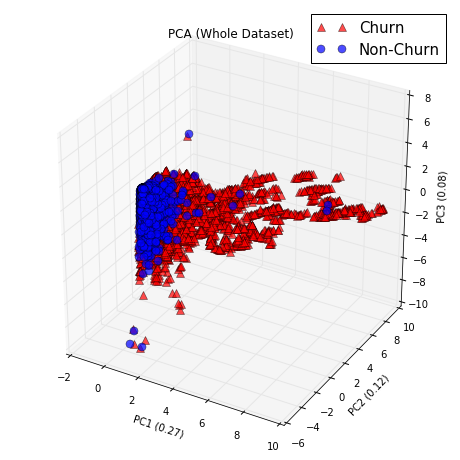

In [184]:
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
posIdx = np.where(ytrain == 1)[0]
negIdx = np.where(ytrain == 0)[0]
ax.plot(pca_transformed[negIdx,0], pca_transformed[negIdx, 1], pca_transformed[negIdx, 2], '^', markersize=8, 
        alpha=0.7, color='red', label='Churn')
ax.plot(pca_transformed[posIdx, 0], pca_transformed[posIdx, 1], pca_transformed[posIdx, 2], 'o', markersize=8, 
        color='blue', alpha=0.7, label='Non-Churn')
ax.set_xlabel('PC1 (%.2f)' % (pca.explained_variance_ratio_[0]))
ax.set_ylabel('PC2 (%.2f)'% (pca.explained_variance_ratio_[1]))
ax.set_zlabel('PC3 (%.2f)' % (pca.explained_variance_ratio_[2]))
plt.title("PCA (Whole Dataset)")
ax.legend(loc='upper right')
plt.show()

Plot 2 dimensions at a time

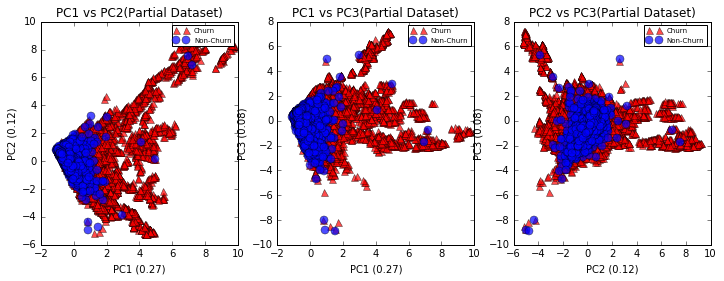

In [185]:
fig = plt.figure(figsize=(12,4))
PCs = [(0, 1), (0, 2), (1, 2)]
i = 1
for pc in PCs:
    ax = fig.add_subplot(130 + i)
    ax.plot(pca_transformed[negIdx,pc[0]], pca_transformed[negIdx, pc[1]], '^', markersize=7, alpha=0.7, 
            color='red', label='Churn')
    ax.plot(pca_transformed[posIdx, pc[0]], pca_transformed[posIdx, pc[1]], 'o', markersize=8, 
        color='blue', alpha=0.7, label='Non-Churn')
    ax.set_xlabel('PC' + str(pc[0] + 1) + ' (%.2f)' % (pca.explained_variance_ratio_[pc[0]]))
    ax.set_ylabel('PC' + str(pc[1] + 1) + ' (%.2f)'% (pca.explained_variance_ratio_[pc[1]]))
    plt.rcParams['legend.fontsize'] = 7
    plt.title("PC" + str(pc[0] + 1) + " vs " + "PC" + str(pc[1] + 1) +  "(Partial Dataset)")
    ax.legend(loc='upper right')
    i += 1
plt.show()

The plots look even better now after feature selection! It looks like the decision tree indeed were able to pick out the best features for separating the two classes. 